<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/GenerativeModelDemo/blob/main/PresentationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00


In [3]:
import torch
from diffusers import StableDiffusionAdapterPipeline, T2IAdapter
import os
import kagglehub
import shutil
import pandas as pd
import numpy as np
from PIL import Image
from datasets import Dataset

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
!pwd

/content


In [5]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("adityajn105/flickr8k")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

100%|██████████| 1.04G/1.04G [00:11<00:00, 101MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1
Download Dataset Complete


In [6]:
df = pd.read_csv("./dataset/captions.txt")
df.rename(columns={'image':"filename"}, inplace=True)
df.loc[:1000]

filename  \
0     1000268201_693b08cb0e.jpg   
1     1000268201_693b08cb0e.jpg   
2     1000268201_693b08cb0e.jpg   
3     1000268201_693b08cb0e.jpg   
4     1000268201_693b08cb0e.jpg   
...                         ...   
996    124195430_d14028660f.jpg   
997    124195430_d14028660f.jpg   
998    124195430_d14028660f.jpg   
999    124195430_d14028660f.jpg   
1000  1244140539_da4804d828.jpg   

                                                caption  
0     A child in a pink dress is climbing up a set o...  
1                 A girl going into a wooden building .  
2      A little girl climbing into a wooden playhouse .  
3     A little girl climbing the stairs to her playh...  
4     A little girl in a pink dress going into a woo...  
...                                                 ...  
996   A brown horse stands near a black horse that i...  
997   A large brown horse stands over a small black ...  
998   An adult horse approaching a foal on a sandy p...  
999   A thin brown horse standing and a small black ...  
1000  A black and brown dog is laying on a white sha...  

[1001 rows x 2 columns]

In [7]:
df["caption"].tolist()

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .',
 'A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails pain

In [8]:
def load_image(example):
    image_path = os.path.join("./dataset/Images", example["filename"])
    image = Image.open(image_path).convert("RGB")
    image = image.resize((64, 64))
    example['images'] = image
    conditioning_image = image.resize((8, 8))
    conditioning_image = conditioning_image.resize((64, 64), resample=Image.Resampling.NEAREST)
    example['conditioning_images'] = conditioning_image

    return example

dataset = Dataset.from_pandas(df.loc[:50])
dataset = dataset.map(load_image)
dataset[0]

Map:   0%|          | 0/51 [00:00<?, ? examples/s]

{'filename': '1000268201_693b08cb0e.jpg',
 'caption': 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 'images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64>,
 'conditioning_images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64>}

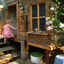

In [9]:
dataset[0]['images']

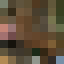

In [10]:
dataset[0]["conditioning_images"]

In [36]:
dataset[0]

{'filename': '1000268201_693b08cb0e.jpg',
 'caption': 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 'images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64>,
 'conditioning_images': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=64x64>}

In [11]:
adapter = T2IAdapter.from_pretrained("TencentARC/t2iadapter_color_sd14v1", torch_dtype=torch.float16)
pipe = StableDiffusionAdapterPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    adapter=adapter,
    torch_dtype=torch.float16,
)
pipe.to("cuda")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

An error occurred while trying to fetch TencentARC/t2iadapter_color_sd14v1: TencentARC/t2iadapter_color_sd14v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/74.8M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)oints%2Fscheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

(…)ure_extractor%2Fpreprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker%2Fconfig.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionAdapterPipeline {
  "_class_name": "StableDiffusionAdapterPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "adapter": [
    "diffusers",
    "T2IAdapter"
  ],
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [12]:
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms

# DataLoader function
def collate_fn(batch):
    images = [example["images"] for example in batch]
    conditions = [example["conditioning_images"] for example in batch]
    texts = [example["caption"] for example in batch]
    return images, conditions, texts

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Define optimizer
optimizer = torch.optim.Adam(pipe.adapter.parameters(), lr=1e-4)

# Convert Image to pytorch tensor and move to GPU
transform = transforms.Compose([
    transforms.PILToTensor()
])

In [13]:
images, conditioning_images, texts = next(iter(dataloader))
images = [transform(img) for img in images]
images = torch.stack(images)
images.shape

torch.Size([4, 3, 64, 64])

In [14]:
# Training loop
for epoch in range(10):  # Number of epochs
    for images, conditioning_images, texts in dataloader:
        optimizer.zero_grad()

        # Move to GPU
        images = [transform(img).type(torch.float16) for img in images]
        images = torch.stack(images)
        images = images.to("cuda")

        conditioning_images = [transform(cond).type(torch.float16) for cond in conditioning_images]
        conditioning_images = torch.stack(conditioning_images)
        conditioning_images = conditioning_images.to("cuda")

        # Generate latents
        latents = pipe.vae.encode(images).latent_dist.sample()
        latents = latents * 0.18215  # Scale latents

        # Generate conditioning latents
        cond_latents = pipe.vae.encode(conditioning_images).latent_dist.sample()
        cond_latents = cond_latents * 0.18215

        # Text
        input_ids = pipe.tokenizer(
            texts, padding=True, truncation=True, return_tensors="pt"
        ).input_ids.to("cuda")
        encoder_hidden_states = pipe.text_encoder(input_ids).last_hidden_state.to("cuda")

        # Compute loss (MSE loss)
        noise = torch.randn_like(latents)
        noisy_latents = latents + noise

        timestep = torch.randint(1, 1000, (1,), device=pipe.device).type(torch.float16)

        predicted_noise = pipe.unet(noisy_latents, timestep, encoder_hidden_states, cond_latents).sample
        loss = F.mse_loss(predicted_noise, noise)

        # Backpropagation
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} Loss: {loss.item()}")

Epoch 0 Loss: 0.36328125
Epoch 1 Loss: 0.197509765625
Epoch 2 Loss: 0.177978515625
Epoch 3 Loss: 0.38427734375
Epoch 4 Loss: 0.2120361328125
Epoch 5 Loss: 0.2310791015625
Epoch 6 Loss: 0.2498779296875
Epoch 7 Loss: 0.23095703125
Epoch 8 Loss: 0.42724609375
Epoch 9 Loss: 0.43408203125


แก้ error โดยการ reshape encoder_hidden_states

In [73]:
print("Encoder hidden states shape:", encoder_hidden_states.shape)

# ถ้าขนาดไม่ถูกต้อง ให้ reshape ใหม่
if encoder_hidden_states.shape[1] != 77:
    print("Reshaping encoder_hidden_states...")
    encoder_hidden_states = torch.nn.functional.interpolate(
        encoder_hidden_states.permute(0, 2, 1), size=(77,), mode="nearest"
    ).permute(0, 2, 1)

print("New Encoder hidden states shape:", encoder_hidden_states.shape)


Encoder hidden states shape: torch.Size([3, 77, 768])
New Encoder hidden states shape: torch.Size([3, 77, 768])


In [68]:
from PIL import Image

conditioning_img = dataset[0]["conditioning_images"]
conditioning_img = conditioning_img.resize((256, 256))  # ปรับขนาด

generator = torch.manual_seed(0)

out_image = pipe(
    prompt="A child in a pink dress is climbing up a set of stairs in an entry way.",
    image=conditioning_img,
    generator=generator,
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

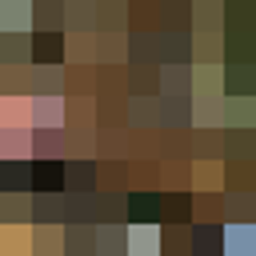

In [69]:
display(conditioning_img)

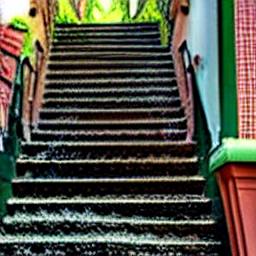

In [70]:
display(out_image)

  0%|          | 0/50 [00:00<?, ?it/s]

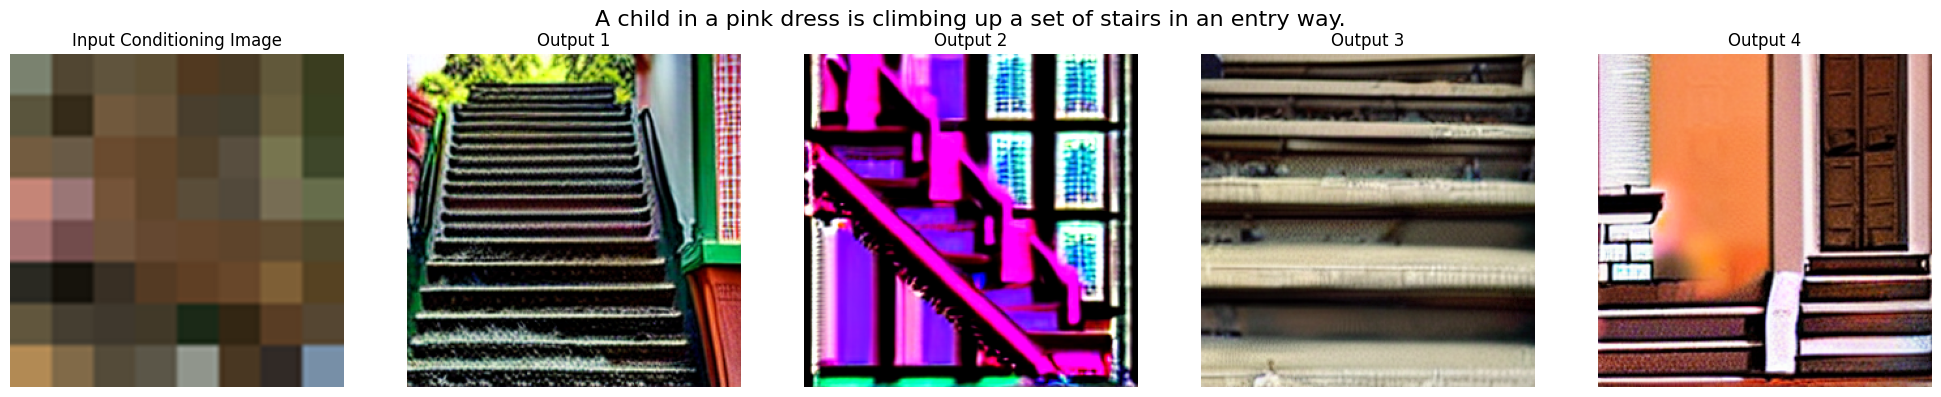

In [71]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

conditioning_img = dataset[0]["conditioning_images"]
conditioning_img = conditioning_img.resize((256, 256))  # ปรับขนาด

prompt = "A child in a pink dress is climbing up a set of stairs in an entry way."

generator = torch.manual_seed(0)

result = pipe(
    prompt=prompt,
    image=conditioning_img,
    generator=generator,
    num_images_per_prompt=4
)

output_images = result.images

num_outputs = len(output_images)
fig, axs = plt.subplots(1, num_outputs + 1, figsize=(4 * (num_outputs + 1), 4))

axs[0].imshow(conditioning_img)
axs[0].set_title("Input Conditioning Image")
axs[0].axis("off")

for i, img in enumerate(output_images):
    axs[i+1].imshow(img)
    axs[i+1].set_title(f"Output {i+1}")
    axs[i+1].axis("off")

plt.suptitle(prompt, fontsize=16)
plt.tight_layout()
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

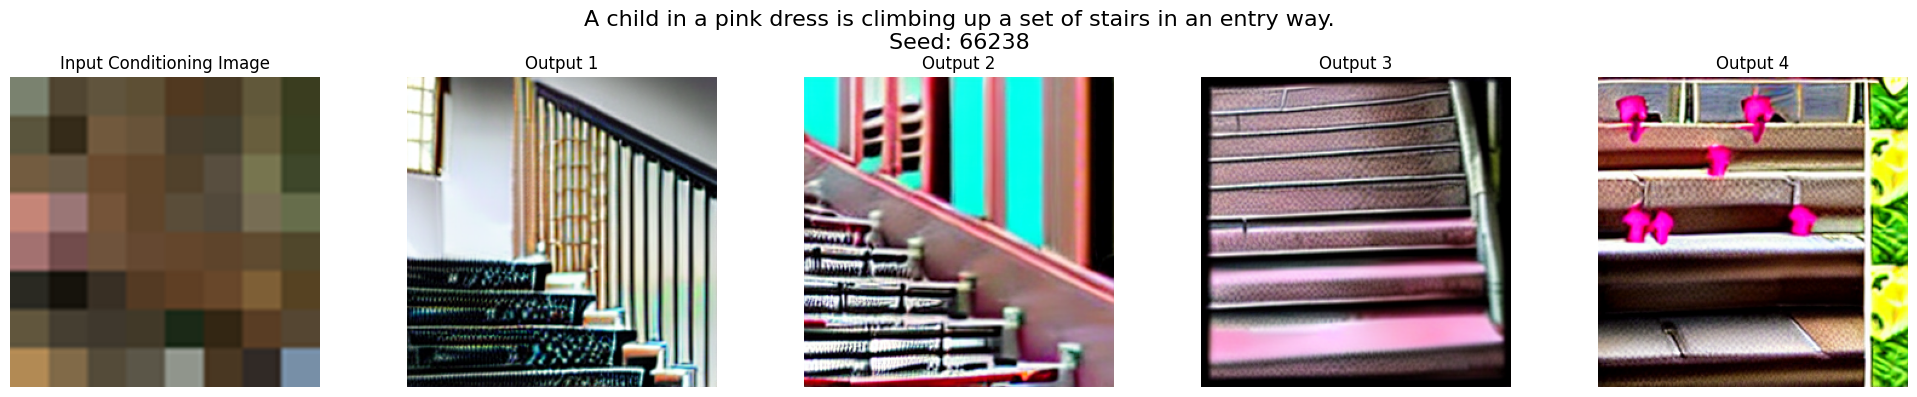

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


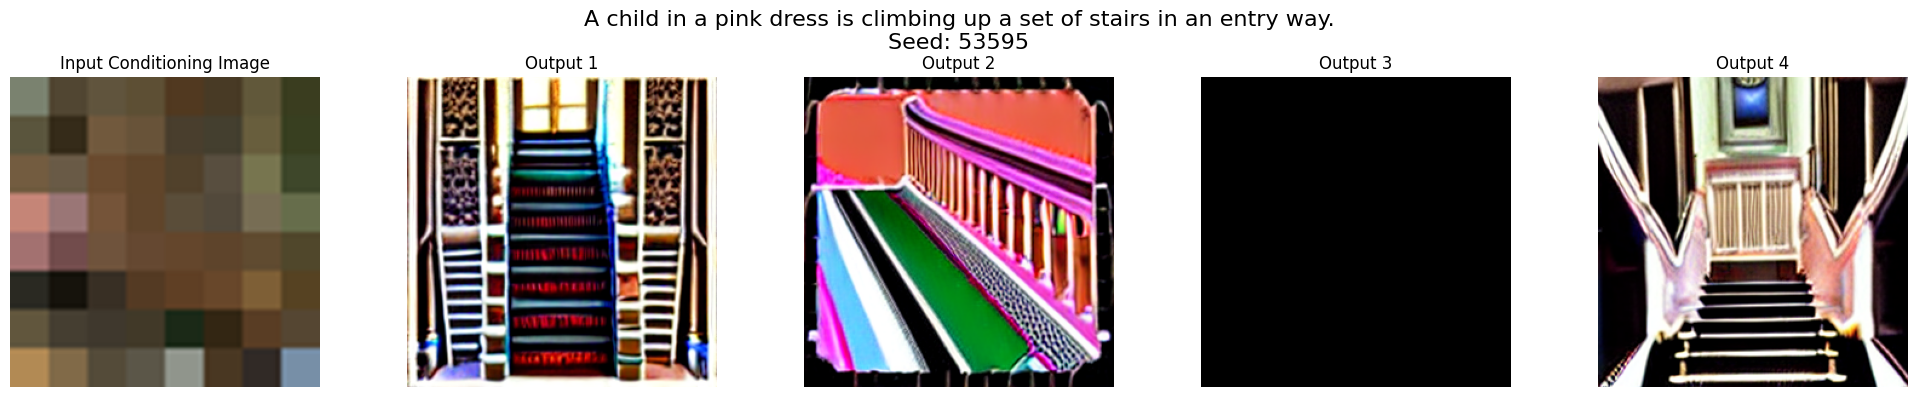

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


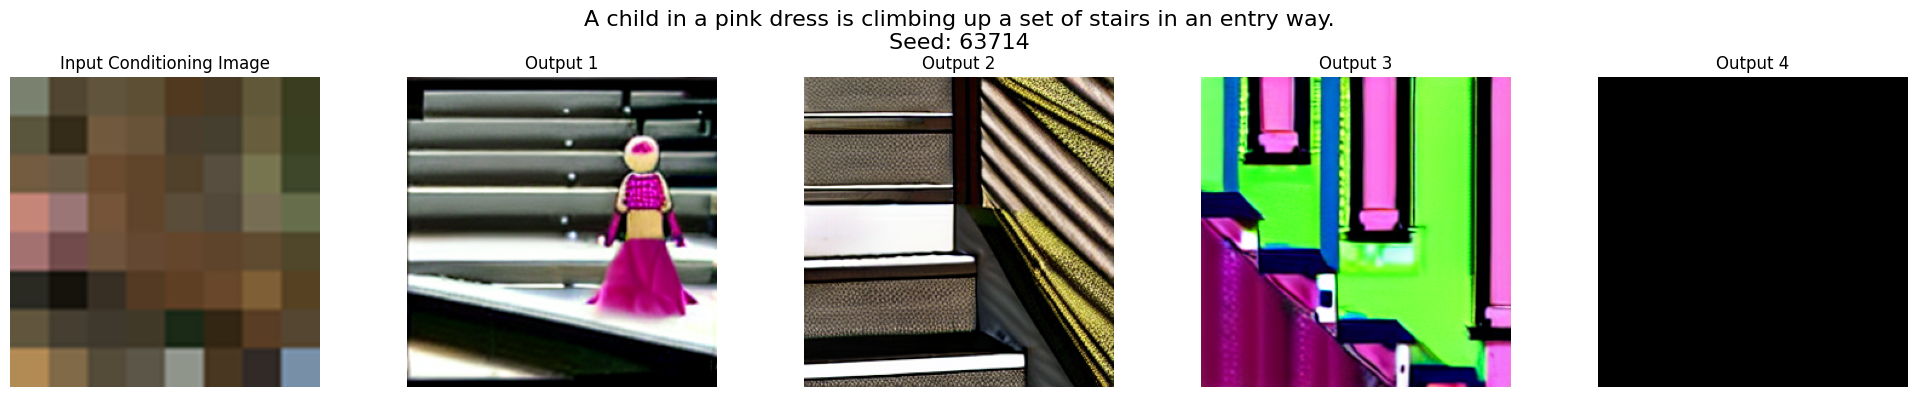

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [72]:
import torch
import random
from PIL import Image
import matplotlib.pyplot as plt
import time

# โหลด conditioning image และปรับขนาด
conditioning_img = dataset[0]["conditioning_images"]
conditioning_img = conditioning_img.resize((256, 256))

prompt = "A child in a pink dress is climbing up a set of stairs in an entry way."

# Loop ที่จะสุ่มผลลัพธ์เรื่อย ๆ
while True:
    # สุ่ม seed ใหม่ทุกครั้ง
    random_seed = random.randint(0, 100000)
    generator = torch.manual_seed(random_seed)

    # สร้าง output หลายรูป (เช่น 4 รูป) ด้วย num_images_per_prompt
    result = pipe(
        prompt=prompt,
        image=conditioning_img,  # ส่งรูป conditioning แบบ raw
        generator=generator,
        num_images_per_prompt=4
    )
    output_images = result.images

    # แสดงผลด้วย Matplotlib
    num_outputs = len(output_images)
    fig, axs = plt.subplots(1, num_outputs + 1, figsize=(4 * (num_outputs + 1), 4))

    # แสดง input image (conditioning image)
    axs[0].imshow(conditioning_img)
    axs[0].set_title("Input Conditioning Image")
    axs[0].axis("off")

    # แสดง output images
    for i, img in enumerate(output_images):
        axs[i+1].imshow(img)
        axs[i+1].set_title(f"Output {i+1}")
        axs[i+1].axis("off")

    plt.suptitle(f"{prompt}\nSeed: {random_seed}", fontsize=16)
    plt.tight_layout()
    plt.show()

    # หยุดแสดงผลชั่วคราว แล้วปิด figure เพื่อเตรียมแสดงผลครั้งต่อไป
    time.sleep(3)  # แสดงผล 3 วินาที
    plt.close('all')

  0%|          | 0/50 [00:00<?, ?it/s]

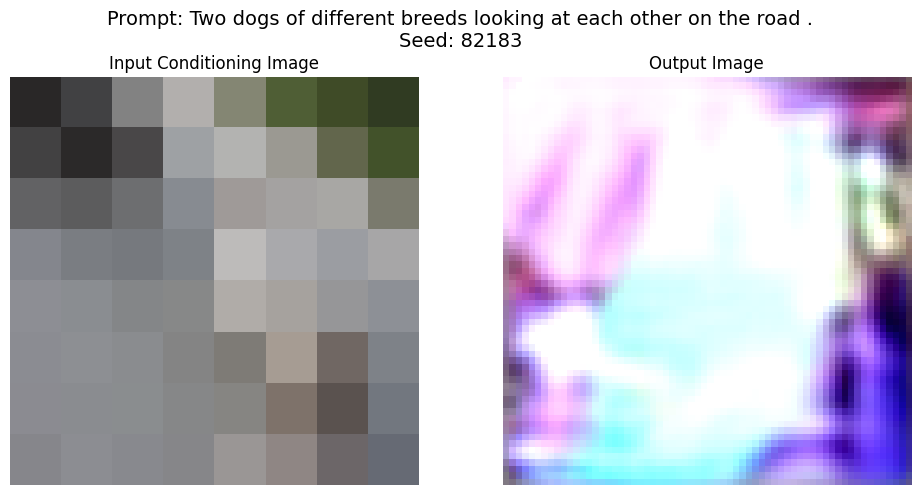

In [64]:
import random
import matplotlib.pyplot as plt
from IPython.display import display

while True:
    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]

    conditioning_image = sample["conditioning_images"]
    prompt = sample["caption"]

    random_seed = random.randint(0, 100000)
    generator = torch.manual_seed(random_seed)

    # เรียก pipeline เพื่อ generate output image
    result = pipe(
        prompt=prompt,
        image=conditioning_image,
        generator=generator,
        num_images_per_prompt=1
    )
    out_image = result.images[0]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(conditioning_image)
    axs[0].set_title("Input Conditioning Image")
    axs[0].axis("off")

    axs[1].imshow(out_image)
    axs[1].set_title("Output Image")
    axs[1].axis("off")

    plt.suptitle(f"Prompt: {prompt}\nSeed: {random_seed}", fontsize=14)
    plt.tight_layout()
    plt.show()

    # ถ้าต้องการสุ่มต่อเนื่อง ให้ comment out บรรทัด break
    break


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

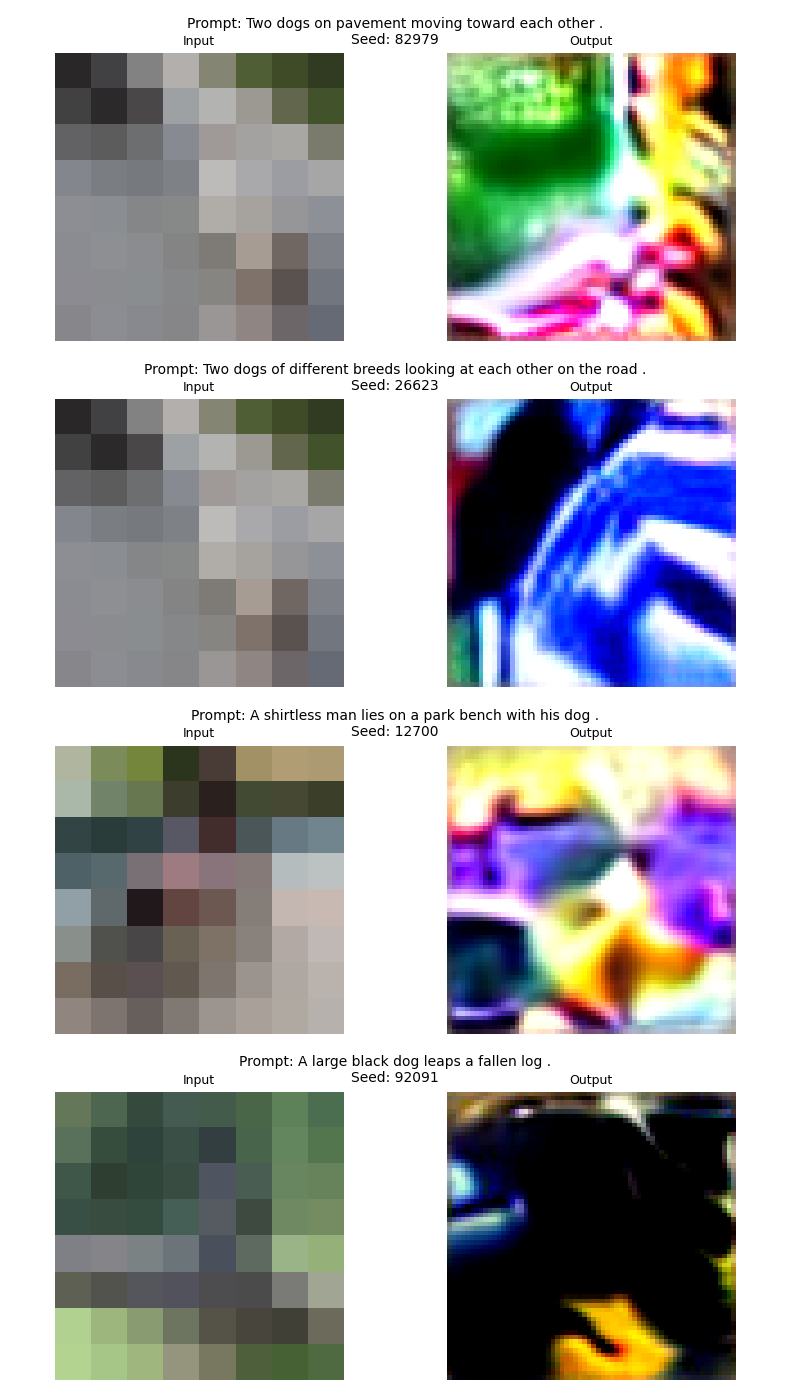

In [63]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch

# กำหนดจำนวนตัวอย่าง
num_samples = 4

samples = []
for _ in range(num_samples):
    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]
    conditioning_image = sample["conditioning_images"]
    prompt = sample["caption"]

    valid_seed_found = False
    max_retries = 5  # จำนวนครั้งสูงสุดที่ลองสุ่ม
    retries = 0

    while not valid_seed_found and retries < max_retries:
        random_seed = random.randint(0, 100000)
        generator = torch.manual_seed(random_seed)

        result = pipe(
            prompt=prompt,
            image=conditioning_image,
            generator=generator,
            num_images_per_prompt=1,
        )
        out_image = result.images[0]

        # ตรวจสอบว่าภาพไม่เป็นสีดำ (NSFW)
        if not out_image.getbbox():
            retries += 1
        else:
            valid_seed_found = True
            samples.append({
                "prompt": prompt,
                "seed": random_seed,
                "input_img": conditioning_image,
                "output_img": out_image
            })

    if not valid_seed_found:
        samples.append({
            "prompt": prompt,
            "seed": random_seed,
            "input_img": conditioning_image,
            "output_img": out_image
        })

# ส่วนสร้างกราฟ
fig = plt.figure(figsize=(8, num_samples*3.5))
gs = gridspec.GridSpec(num_samples, 2, height_ratios=[1]*num_samples, width_ratios=[1,1])

for i, sample in enumerate(samples):
    row_gs = gs[i, :].subgridspec(2, 2, height_ratios=[0.15, 1], hspace=0)

    text_ax = fig.add_subplot(row_gs[0, :])
    text_ax.axis('off')
    text_ax.text(0.5, 0.5,
                f"Prompt: {sample['prompt']}\nSeed: {sample['seed']}",
                ha='center', va='center',
                fontsize=10, wrap=True)

    ax_input = fig.add_subplot(row_gs[1, 0])
    ax_input.imshow(sample['input_img'])
    ax_input.axis('off')
    ax_input.set_title("Input", fontsize=9)

    ax_output = fig.add_subplot(row_gs[1, 1])
    ax_output.imshow(sample['output_img'])
    ax_output.axis('off')
    ax_output.set_title("Output", fontsize=9)

plt.tight_layout()
plt.show()

code gen อันเก่า

In [47]:
# generator = torch.manual_seed(0)

# out_image = pipe(
#     "At night, glowing cubes in front of the beach",
#     image=...,
#     generator=generator,
# ).images[0]